<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master//bgsedsc_0.jpg">

# Project: Unsupervised learning

## Programming project: patient clustering

In this project, you have to cluster patients that enter an ICU (Intensive Care Unit) by the features that are known on the very first day. At the end, we will check if these groups of patients have similar outcome results, in terms of length of stay or probability of death.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_unsupervised_features.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Most columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 



Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Additionally, the file *mimic_unsupervised_response.csv* contains the outcome of the patients visit to the ICU, did they die and how many days were they in the ICU for. We will use this to evaluate the clusters we produce.


Main tasks are:
+ Using *mimic_unsupervised_features.csv* file to cluster patient stays .
+ Using *mimic_unsupervised_response.csv*, check if resulting clusters are related to outcomes of patients, such as length of stay, mortality or assigned ICU.

You can follow these **steps** for your implementation:
1. *Explore* and understand the dataset. 
2. For your *first* implmentation

   i). Remove all non numeric columns (e.g ID's, dates and categories)   
   ii). Standardise the data to have 0 column means and variance 1   
   iii). Cluster the data using either K-means or spectral clustering. Show how you decided how many clusters to use

3. Then use the single valued decomposition (SVD) to reduce the dimensionality of the numerical feature space. Show how you decided how many dimensions to use. See how this affects your clustering

4. Manage the date variables e.g. try to create an Age variable, and manage categorial features e.g. create *dummy variables* for relevant categorical features.  See how this affects your clustering

5. Consider how to incorporate the comorbidity information.

6. Explore relationship between clusters and outcomes of patients

Feel free to reduce the dataset if you experience computational constraints.
As a *bonus*, explore if adding as an input feature the cluster label would improve a prediction model of mortality (e.g. try with LogisticRegression, or any non-linear model of your choice).

## Main criteria for grading – In Class
With weights for In-Class:
+ Code runs - 20%
+ Data preparation - 20%
+ Clustering algorithm used - 25%
+ Reasonable selection of number of clusters demonstrated - 25% 
+ SVD used - 5%
+ Reasonable selection of number of dimensions - 5%
+ Good exploration of relation between clusters and patient outcomes - 0%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

# **Data Preparation**

In [83]:
#Step 0: Load data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
import os
os.chdir('/content/drive/My Drive/cml1_inclass3')

In [85]:
import pandas as pd
feat = pd.read_csv("mimic_unsupervised_features.csv", index_col=0)
feat

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,2108-07-16 00:00:00,2178-02-06 10:35:00,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU
1,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,F,2087-01-16 00:00:00,2129-02-12 22:34:00,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU
2,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,F,2057-09-17 00:00:00,2125-11-17 23:04:00,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU
3,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,94.0,62.783784,12.0,35.0,26.771429,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,F,2056-02-27 00:00:00,2131-01-26 08:00:00,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU
5,63311,180102,287519,70.0,130.0,97.951220,107.0,155.0,128.414634,60.0,88.0,74.780488,72.0,100.0,86.820513,10.0,23.0,15.707317,36.000000,36.944444,36.591270,96.0,100.0,98.878049,92.0,142.0,104.400000,M,2102-06-04 00:00:00,2151-08-06 19:11:00,-51044.77754,EMERGENCY,Private,CATHOLIC,SINGLE,WHITE,LARGE GASTOINTESTINAL BLEED,5550,MICU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,28043,135417,244530,65.0,92.0,78.500000,60.0,160.0,110.976190,34.0,94.0,56.595238,41.0,102.0,69.285714,10.0,23.0,15.420000,35.555556,36.611111,36.155556,97.0,100.0,99.833333,68.0,139.0,103.571429,M,2088-12-15 00:00:00,2176-06-17 06:36:00,-60714.92678,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,ALTERED MENTAL STATUS,3229,MICU
20881,87605,191007,216116,74.0,112.0,89.156250,100.0,150.0,123.272727,58.0,83.0,67.818182,74.0,99.0,82.363636,9.0,24.0,14.781250,37.055556,37.777778,37.476190,95.0,100.0,97.531250,184.0,377.0,245.400000,M,2071-11-18 00:00:00,2137-09-27 23:14:00,-46217.77777,EMERGENCY,Private,NOT SPECIFIED,MARRIED,BLACK/HAITIAN,NEW BRAIN MASS,1918,SICU
20882,47492,152608,274507,58.0,97.0,76.933333,94.0,131.0,112.037037,55.0,83.0,67.370370,66.0,95.0,78.500000,14.0,27.0,18.166667,36.055556,37.277778,37.007937,97.0,100.0,99.200000,51.0,460.0,190.000000,F,2055-11-27 00:00:00,2118-10-18 17:54:00,-39830.10848,EMERGENCY,Private,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,HYPOGLYCEMIA,24980,MICU
20883,62946,191485,225930,59.0,102.0,81.844444,96.0,150.0,123.837209,47.0,85.0,60.232558,65.0,92.0,75.883721,15.0,27.0,19.044444,35.833333,37.722222,36.635417,91.0,100.0,96.311111,91.0,91.0,91.000000,F,1871-07-17 00:00:00,2171-07-17 21:24:00,-59205.26841,EMERGENCY,Medicare,PROTESTANT QUAKER,WIDOWED,WHITE,CORONARY ARTERY DISEASE\PERCUTANEOUS CORONARY ...,41401,CCU


In [86]:
# Check which variables are neither int or float and drop
print(feat.dtypes)
new_feat = feat.drop(["GENDER", "DOB", "ADMITTIME", "ADMISSION_TYPE", "INSURANCE", "RELIGION", "MARITAL_STATUS", "ETHNICITY", "DIAGNOSIS", "ICD9_diagnosis", "FIRST_CAREUNIT"] ,axis = 1)
new_feat

subject_id          int64
hadm_id             int64
icustay_id          int64
HeartRate_Min     float64
HeartRate_Max     float64
HeartRate_Mean    float64
SysBP_Min         float64
SysBP_Max         float64
SysBP_Mean        float64
DiasBP_Min        float64
DiasBP_Max        float64
DiasBP_Mean       float64
MeanBP_Min        float64
MeanBP_Max        float64
MeanBP_Mean       float64
RespRate_Min      float64
RespRate_Max      float64
RespRate_Mean     float64
TempC_Min         float64
TempC_Max         float64
TempC_Mean        float64
SpO2_Min          float64
SpO2_Max          float64
SpO2_Mean         float64
Glucose_Min       float64
Glucose_Max       float64
Glucose_Mean      float64
GENDER             object
DOB                object
ADMITTIME          object
Diff              float64
ADMISSION_TYPE     object
INSURANCE          object
RELIGION           object
MARITAL_STATUS     object
ETHNICITY          object
DIAGNOSIS          object
ICD9_diagnosis     object
FIRST_CAREUN

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff
0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,-61961.78470
1,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,-43146.18378
2,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,-42009.96157
3,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,94.0,62.783784,12.0,35.0,26.771429,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,-43585.37922
5,63311,180102,287519,70.0,130.0,97.951220,107.0,155.0,128.414634,60.0,88.0,74.780488,72.0,100.0,86.820513,10.0,23.0,15.707317,36.000000,36.944444,36.591270,96.0,100.0,98.878049,92.0,142.0,104.400000,-51044.77754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,28043,135417,244530,65.0,92.0,78.500000,60.0,160.0,110.976190,34.0,94.0,56.595238,41.0,102.0,69.285714,10.0,23.0,15.420000,35.555556,36.611111,36.155556,97.0,100.0,99.833333,68.0,139.0,103.571429,-60714.92678
20881,87605,191007,216116,74.0,112.0,89.156250,100.0,150.0,123.272727,58.0,83.0,67.818182,74.0,99.0,82.363636,9.0,24.0,14.781250,37.055556,37.777778,37.476190,95.0,100.0,97.531250,184.0,377.0,245.400000,-46217.77777
20882,47492,152608,274507,58.0,97.0,76.933333,94.0,131.0,112.037037,55.0,83.0,67.370370,66.0,95.0,78.500000,14.0,27.0,18.166667,36.055556,37.277778,37.007937,97.0,100.0,99.200000,51.0,460.0,190.000000,-39830.10848
20883,62946,191485,225930,59.0,102.0,81.844444,96.0,150.0,123.837209,47.0,85.0,60.232558,65.0,92.0,75.883721,15.0,27.0,19.044444,35.833333,37.722222,36.635417,91.0,100.0,96.311111,91.0,91.0,91.000000,-59205.26841


subject_id        0
hadm_id           0
icustay_id        0
HeartRate_Min     0
HeartRate_Max     0
HeartRate_Mean    0
SysBP_Min         0
SysBP_Max         0
SysBP_Mean        0
DiasBP_Min        0
DiasBP_Max        0
DiasBP_Mean       0
MeanBP_Min        0
MeanBP_Max        0
MeanBP_Mean       0
RespRate_Min      0
RespRate_Max      0
RespRate_Mean     0
TempC_Min         0
TempC_Max         0
TempC_Mean        0
SpO2_Min          0
SpO2_Max          0
SpO2_Mean         0
Glucose_Min       0
Glucose_Max       0
Glucose_Mean      0
Diff              0
dtype: int64


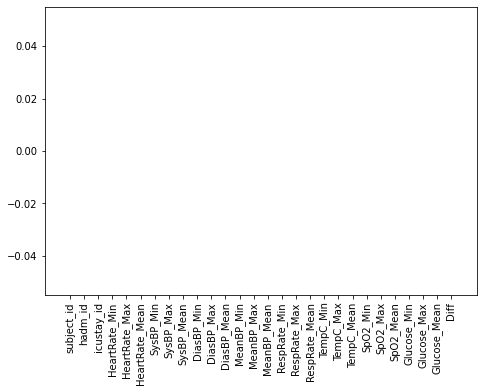

In [95]:
# Chechk for NaNs
nulls = new_feat.isnull().sum()
print(nulls) #None

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(new_feat.columns, nulls)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Standardize data (so distance measures are in equivalent units)
from sklearn import preprocessing

# Instantiate scaler
scaler = preprocessing.StandardScaler()

# Fit to data
new_feat_scl = scaler.fit_transform(new_feat)
new_feat_scl = pd.DataFrame(new_feat_scl, columns = new_feat.columns, index = new_feat.index)
new_feat_scl


,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff
0,-0.276167,1.586136,-0.753548,1.301707,1.899425,2.340528,-0.995439,-1.004336,-0.759513,-0.192319,0.076030,-0.124181,0.189723,-0.478223,-0.277665,0.871632,0.343915,0.870813,-1.321010,-0.627331,-1.154524,-0.158336,-0.519960,-0.528409,0.153663,0.485485,0.493449,-0.973831
1,0.604331,-0.828681,-1.008244,-0.466027,0.226911,-0.397077,-0.127782,-1.257527,-0.750725,0.398642,-0.756787,0.200826,0.119377,-0.842534,-0.254462,0.305358,-1.088160,-0.761286,0.394306,-1.053061,-0.483318,0.990488,0.408119,1.006762,-0.086559,-0.854867,-0.812052,0.786523
2,1.379095,-0.464232,1.600413,0.757789,-0.346523,0.423830,-0.185626,-0.540152,-0.387341,0.060950,-1.121145,-0.521601,0.541451,-0.696810,-0.427327,0.305358,-1.088160,-0.802503,0.550243,-0.698286,-0.150358,1.277694,0.408119,1.442003,0.784246,1.709743,1.778180,0.892826
3,-0.880393,-1.648197,-0.157766,0.417840,1.087061,0.891841,-0.417001,-0.666747,-0.736337,-1.205394,0.023979,-1.887269,-0.584078,-0.478223,-1.341359,0.022220,1.139512,2.018810,0.394306,2.636598,1.847403,-1.881573,0.408119,-0.830577,0.063580,-0.474925,-0.314957,0.745432
5,0.046658,1.042844,1.295733,0.009901,1.182633,0.832687,0.913407,0.177224,0.551016,1.327295,-0.028072,1.118221,1.104215,-0.259636,0.832823,-0.544054,-0.769921,-0.852508,-0.073508,-0.627331,-0.279465,0.703282,0.408119,0.923164,-0.416864,-0.443263,-0.780418,0.047544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,-1.399841,-0.506819,-0.193340,-0.330048,-0.633239,-0.437407,-1.805253,0.388217,-0.495985,-0.867702,0.284235,-0.542255,-1.076497,-0.186773,-0.753243,-0.544054,-0.769921,-0.927071,-0.697259,-1.053061,-1.025568,0.846885,0.408119,1.364929,-1.137530,-0.474925,-0.799140,-0.857177
20881,1.043063,1.421026,-1.177557,0.281860,0.322483,0.258408,0.508500,-0.033769,0.242297,1.158449,-0.288327,0.482500,1.244906,-0.296067,0.429688,-0.827192,-0.610801,-1.092837,1.407901,0.436993,1.235844,0.559679,0.408119,0.300345,2.345689,2.036916,2.405506,0.499150
20882,-0.602150,0.089360,0.845017,-0.805976,-0.394309,-0.539705,0.161437,-0.835542,-0.432292,0.905180,-0.288327,0.441611,0.682142,-0.441791,0.080212,0.588495,-0.133443,-0.214266,0.004461,-0.201601,0.434021,0.846885,0.408119,1.072048,-1.648001,2.912894,1.153731,1.096769
20883,0.031687,1.437603,-0.837615,-0.737986,-0.155378,-0.219027,0.277125,-0.033769,0.276189,0.229796,-0.184225,-0.210135,0.611796,-0.551085,-0.156437,0.871632,-0.133443,0.013531,-0.307415,0.366039,-0.203869,-0.014733,0.408119,-0.263900,-0.446892,-0.981515,-1.083194,-0.715936


# **$k$-Means Clustering**

Let's try doing $k$-means clustering with different values of clusters and inspect the results.

In [ ]:
#K-means clustering
from sklearn.cluster import KMeans

print(new_feat_scl.shape) #28 features

# Estimate k-means for various n clusters and save the inertia/within-cluster sum-of-squares
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(new_feat_scl) #Run time: 2m 24s
    wcss.append(kmeans.inertia_)

(17476, 28)


Text(0, 0.5, 'WCSS \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

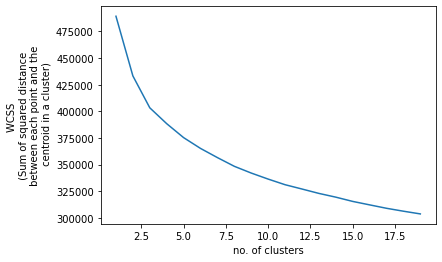

In [ ]:
# Visualize the results
import matplotlib.pyplot as plt

plt.plot(range(1, 20), wcss)
plt.xlabel("no. of clusters")
plt.ylabel('WCSS \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

The location of the elbow is ambiguous. I would say it is in the region $[2.5,10.0]$. I will choose it to be $5$.

# **SVD**

Now, I do single value decomposition.

In [ ]:
import numpy as np
u, s, v = np.linalg.svd(new_feat_scl, full_matrices = True) #Run time: 23s

In [ ]:
print(new_feat_scl.shape)
print(u.shape)
print(s.shape)
print(v.shape)

(17476, 28)
(17476, 17476)
(28,)
(28, 28)


Text(0.5, 0, 'SVs')

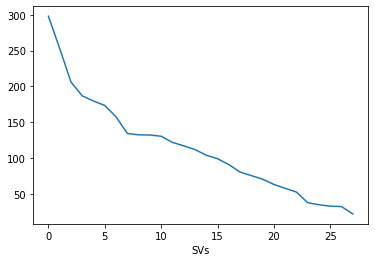

In [ ]:
# Plot the single values
plt.plot(s)
plt.xlabel("SVs")

Like the previous figure, the location of the elbow is ambiguous. For now, I will determine it to be at $5$.

In [ ]:
labels= ['SV'+str(i) for i in range(1,6)]
svd_df = pd.DataFrame(u[:,0:5], columns = labels)
svd_df

,SV1,SV2,SV3,SV4,SV5
0,0.003144,-0.010360,0.006964,-0.004604,-0.002575
1,0.003178,0.005884,-0.007482,-0.002682,-0.005828
2,0.002113,0.002380,0.000485,0.014140,-0.012573
3,0.007429,-0.015384,-0.004646,0.000749,0.003350
4,-0.007119,0.003532,-0.006582,-0.002124,-0.001932
...,...,...,...,...,...
17471,0.007063,0.007726,-0.002788,0.000266,0.010458
17472,-0.006182,-0.000562,0.002390,0.018707,-0.014551
17473,-0.000624,0.003106,0.000283,0.009085,-0.006463
17474,0.000100,0.001978,-0.004257,-0.006379,-0.000333


# **$k$-Means on SVD**

(17476, 5)


Text(0, 0.5, 'WCSS \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

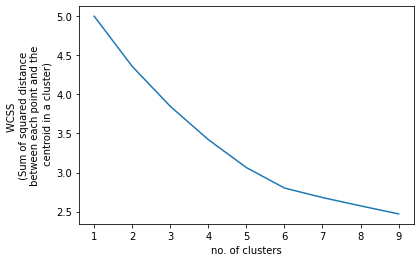

In [ ]:
print(svd_df.shape) #5 SVs

# Estimate k-means for various n clusters and save the inertia/within-cluster sum-of-squares
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(svd_df) #Run time: 9s
    wcss.append(kmeans.inertia_)

# Visualize 
plt.plot(range(1, 10), wcss)
plt.xlabel("no. of clusters")
plt.ylabel('WCSS \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

In this case the elbow is more pronounced to previous attempts. I would say, it is a no. clusters = $6$. So we find more number of clusters than before but now with less dimensions.